In [81]:
# # spark libraries
# import pyspark
# from pyspark.sql.functions import max

# data wrangling
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [82]:
df = pd.read_csv('hard_drives_smart_5.csv').drop(columns='Unnamed: 0')

In [83]:
df.head()

,serial_number,model,capacity_bytes,max(failure),max(smart_9_raw),max(smart_5_raw),max(smart_187_raw),max(smart_188_raw),max(smart_197_raw),max(smart_198_raw)
0,PL1311LAG1SJAA,Hitachi HDS5C4040ALE630,4000787030016,0,43819.0,0.0,NaN,NaN,0.0,0.0
1,Z305KB36,ST4000DM000,4000787030016,0,31045.0,0.0,0.0,0.0,0.0,0.0
2,MJ0351YNG9MZXA,Hitachi HDS5C3030ALA630,3000592982016,0,41668.0,0.0,NaN,NaN,0.0,0.0
3,ZA11NHSN,ST8000DM002,8001563222016,0,26284.0,0.0,0.0,0.0,0.0,0.0
4,MJ1311YNG2ZSEA,Hitachi HDS5C3030ALA630,3000592982016,0,47994.0,0.0,NaN,NaN,0.0,0.0


In [84]:
import pandas as pd
import numpy as np
import re 


def get_manufacturer(model):
    if model.startswith('ST'):
        return 'Seagate'
    elif model.startswith('Sea'):
        return 'Seagate'
    elif model.startswith('HGST'):
        return 'Hitachi'
    elif model.startswith('Hit'):
        return 'Hitachi'
    elif model.startswith('TOS'):
        return 'Toshiba'
    elif model.startswith('DEL'):
        return 'Dell'
    elif model.startswith('WD'):
        return 'Western Digital'
    elif model.startswith('Sam'):
        return 'Samsung'
    elif model.startswith('SAM'):
        return 'Samsung'
    else:
        return 'Unknown'


def prepare(df):
    
    # Convert capacity column from bytes to terabytes
    df['capacity_bytes'] = round((df['capacity_bytes']/ 1_000_000_000_000),1)

    # Convert power hours to years
    df['max(smart_9_raw)'] = round((df['max(smart_9_raw)']/ 8760),1)

    # Create a new column for manufacturer
    df['manufacturer'] = df.model.apply(get_manufacturer)
    
    # Rename columns appropriately
    df = df.rename(columns={'capacity_bytes':'capacity_terabytes',
                        'max(failure)':'failure',
                        'max(smart_9_raw)':'drive_age_in_years',
                        'max(smart_5_raw)':'reallocated_sectors_count',
                        'max(smart_187_raw)':'reported_uncorrectable_errors',
                        'max(smart_188_raw)':'command_timeout',
                        'max(smart_197_raw)':'current_pending_sector_count',
                        'max(smart_198_raw)':'uncorrectable_sector_count'})

    # Reorder columns 
    df = df[['serial_number','manufacturer','model','capacity_terabytes',
          'failure','drive_age_in_years','reallocated_sectors_count',
         'reported_uncorrectable_errors','command_timeout',
          'current_pending_sector_count','uncorrectable_sector_count']]
    
    return df


def unique(df):
    '''
    Remove rows that duplicate serial numbers after aggregation.
    '''
    
    # remove rows with 0 copacity_terabytes they were creating duplicate rows for some of the serial numbers
    df = df[df.capacity_terabytes > 0]
    
    # remove rows by index that were creating duplicate serial numbers 
    df = df.drop([68273,50408,37150,154660,162948,50816,156370,31687,20823,75191,132189,4177,78104,103620,141505,95249,26969])
    
    return df


def treat_nulls(df):
    # remove nulls from specific columns by imputing zeroes
    df.reported_uncorrectable_errors = df.reported_uncorrectable_errors.fillna(value=0)
    df.command_timeout = df.command_timeout.fillna(value=0)
    
    # treat remaining nulls by dropping specific rows
    df = df.dropna(axis=0)
    return df

In [85]:
df = prepare(df)

In [86]:
df = unique(df)

In [87]:
df = treat_nulls(df)

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161830 entries, 0 to 169067
Data columns (total 11 columns):
serial_number                    161830 non-null object
manufacturer                     161830 non-null object
model                            161830 non-null object
capacity_terabytes               161830 non-null float64
failure                          161830 non-null int64
drive_age_in_years               161830 non-null float64
reallocated_sectors_count        161830 non-null float64
reported_uncorrectable_errors    161830 non-null float64
command_timeout                  161830 non-null float64
current_pending_sector_count     161830 non-null float64
uncorrectable_sector_count       161830 non-null float64
dtypes: float64(7), int64(1), object(3)
memory usage: 14.8+ MB


In [89]:
import seaborn as sns 
import matplotlib.pyplot as plt

In [90]:
import pandas as pd 
import numpy as np 


def remove_manufacturers(df):
    # Remove manufactures with low value counts
    df = df[(df.manufacturer != 'Samsung') & (df.manufacturer != 'Unknown')]
    return df


def early_failure(df,cut_off=1.6):
    '''
    Add column to identify early failures based on the age of the hard drive 

    '''
    df['early_failure'] = np.where((df.drive_age_in_years <= cut_off) & (df.failure == 1), 1, 0)
    return df

def old_or_fail(df,cut_off=1.6):
    '''
    Retain rows for drives that have failed or are older than the cut off age
    '''
    df = df[(df.failure==1)|(df.drive_age_in_years > cut_off)]

    return df

def make_binary_values(df):
    df.reallocated_sectors_count = np.where(df.reallocated_sectors_count > 0, '1','0').astype(bool)
    df.reported_uncorrectable_errors = np.where(df.reported_uncorrectable_errors > 0, '1', '0').astype(bool)
    df.command_timeout = np.where(df.command_timeout > 0, '1', '0').astype(bool)
    df.current_pending_sector_count = np.where(df.current_pending_sector_count > 0, '1', '0').astype(bool)
    df.uncorrectable_sector_count = np.where(df.uncorrectable_sector_count > 0, '1', '0').astype(bool)
    return df


def get_quartile(df,Q1=1.6,Q2=2.6,Q3=4):
    '''
    Add colulmn to identify which quartile drive falls in based on the age of the hard drive
    '''
    df['quartile']= 1
    df['quartile'][df.drive_age_in_years<Q1] = 'Q1'
    df['quartile'][(df.drive_age_in_years>=Q1) & (df.drive_age_in_years<Q2)] = 'Q2'
    df['quartile'][(df.drive_age_in_years>=Q2) & (df.drive_age_in_years<Q3)] = 'Q3'
    df['quartile'][(df.drive_age_in_years>=Q3)] = 'Q4'
    return df

In [91]:
df = remove_manufacturers(df)

In [92]:
df = early_failure(df, 2.6)

In [93]:
df = old_or_fail(df, 2.6)

In [94]:
df = make_binary_values(df)

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83940 entries, 0 to 168960
Data columns (total 12 columns):
serial_number                    83940 non-null object
manufacturer                     83940 non-null object
model                            83940 non-null object
capacity_terabytes               83940 non-null float64
failure                          83940 non-null int64
drive_age_in_years               83940 non-null float64
reallocated_sectors_count        83940 non-null bool
reported_uncorrectable_errors    83940 non-null bool
command_timeout                  83940 non-null bool
current_pending_sector_count     83940 non-null bool
uncorrectable_sector_count       83940 non-null bool
early_failure                    83940 non-null int64
dtypes: bool(5), float64(2), int64(2), object(3)
memory usage: 5.5+ MB


In [96]:
df.groupby('failure').sum().iloc[:,2:-1]

,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count
failure,,,,,
0,1541.0,1170.0,2640.0,1152.0,969.0
1,1909.0,2079.0,559.0,2489.0,2190.0


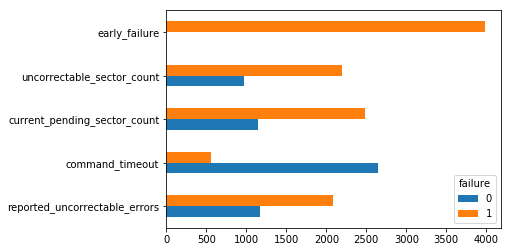

In [97]:
df.groupby('failure').sum().iloc[:,3:].T.plot.barh()
plt.show()

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83940 entries, 0 to 168960
Data columns (total 12 columns):
serial_number                    83940 non-null object
manufacturer                     83940 non-null object
model                            83940 non-null object
capacity_terabytes               83940 non-null float64
failure                          83940 non-null int64
drive_age_in_years               83940 non-null float64
reallocated_sectors_count        83940 non-null bool
reported_uncorrectable_errors    83940 non-null bool
command_timeout                  83940 non-null bool
current_pending_sector_count     83940 non-null bool
uncorrectable_sector_count       83940 non-null bool
early_failure                    83940 non-null int64
dtypes: bool(5), float64(2), int64(2), object(3)
memory usage: 5.5+ MB


In [99]:
df.early_failure.value_counts()

0    79954
1     3986
Name: early_failure, dtype: int64

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


def split_my_data(df):
    # define target and features
    X = df.drop(columns = ['serial_number', 'early_failure', 'failure', 'drive_age_in_years'])
    y = df[['early_failure']]

    # split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .80, random_state = 123, stratify=df.early_failure)
    return X_train, X_test, y_train, y_test

def encode_hot(train, test, col_name):
    encoded_values = sorted(list(train[col_name].unique()))

    # Integer Encoding
    int_encoder = LabelEncoder()
    train.encoded = int_encoder.fit_transform(train[col_name])
    test.encoded = int_encoder.transform(test[col_name])

    # create 2D np arrays of the encoded variable (in train and test)
    train_array = np.array(train.encoded).reshape(len(train.encoded),1)
    test_array = np.array(test.encoded).reshape(len(test.encoded),1)

    # One Hot Encoding
    ohe = OneHotEncoder(sparse=False, categories='auto')
    train_ohe = ohe.fit_transform(train_array)
    test_ohe = ohe.transform(test_array)

    # Turn the array of new values into a data frame with columns names being the values
    # and index matching that of train/test
    # then merge the new dataframe with the existing train/test dataframe
    # and drop original column
    train_encoded = pd.DataFrame(data=train_ohe, columns=encoded_values, index=train.index)
    train = train.join(train_encoded)
    train = train.drop(columns = col_name)

    test_encoded = pd.DataFrame(data=test_ohe, columns=encoded_values, index=test.index)
    test = test.join(test_encoded)
    test = test.drop(columns = col_name)

    return train, test

In [101]:
X_train, X_test, y_train, y_test = split_my_data(df)

In [102]:
X_train.columns

Index(['manufacturer', 'model', 'capacity_terabytes',
       'reallocated_sectors_count', 'reported_uncorrectable_errors',
       'command_timeout', 'current_pending_sector_count',
       'uncorrectable_sector_count'],
      dtype='object')

In [103]:
X_train.drop(columns='manufacturer', inplace=True)
X_test.drop(columns='manufacturer', inplace=True)
X_train.drop(columns='model', inplace=True)
X_test.drop(columns='model', inplace=True)

In [104]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [105]:
def logit_model(X_train, y_train):
    logit = LogisticRegression(solver = 'liblinear', class_weight='balanced', random_state = 123)
    logit.fit(X_train, y_train)
    
    y_pred = logit.predict(X_train)
    y_pred_proba = logit.predict_proba(X_train)

    print(pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(np.transpose(logit.coef_))], axis = 1))
    print()
    print(y_pred_proba)
    print()
    print(confusion_matrix(y_train, y_pred))
    print()    
    print(classification_report(y_train, y_pred))

In [106]:
logit_model(X_train, y_train)

                               0         0
0             capacity_terabytes  0.315160
1      reallocated_sectors_count  1.516272
2  reported_uncorrectable_errors  1.658233
3                command_timeout  0.982494
4   current_pending_sector_count  4.351989
5     uncorrectable_sector_count -1.635453

[[0.00429525 0.99570475]
 [0.78720265 0.21279735]
 [0.78720265 0.21279735]
 ...
 [0.78720265 0.21279735]
 [0.51187411 0.48812589]
 [0.83525048 0.16474952]]

[[61220  2743]
 [  888  2301]]

              precision    recall  f1-score   support

           0       0.99      0.96      0.97     63963
           1       0.46      0.72      0.56      3189

    accuracy                           0.95     67152
   macro avg       0.72      0.84      0.77     67152
weighted avg       0.96      0.95      0.95     67152



In [119]:
def logit_model(X_train, y_train):
    logit = LogisticRegression(solver = 'liblinear', class_weight='balanced', random_state = 123)
    logit.fit(X_train, y_train)
    
    y_pred = logit.predict(X_train)
    y_pred_proba = logit.predict_proba(X_train)
    
    print(confusion_matrix(y_train, y_pred))
    print()
    print(classification_report(y_train, y_pred))

In [120]:
logit_model(X_train, y_train)

[[61220  2743]
 [  888  2301]]

              precision    recall  f1-score   support

           0       0.99      0.96      0.97     63963
           1       0.46      0.72      0.56      3189

    accuracy                           0.95     67152
   macro avg       0.72      0.84      0.77     67152
weighted avg       0.96      0.95      0.95     67152



In [134]:
from sklearn.neighbors import KNeighborsClassifier

def knn_modeling_function(X_train, y_train):
    knn = KNeighborsClassifier(n_neighbors=3, weights = 'distance')
    knn.fit(X_train, y_train)
    y_pred=knn.predict(X_train)

    print(confusion_matrix(y_train, y_pred))
    print()
    print(classification_report(y_train, y_pred))

In [128]:
knn_modeling_function(X_train, y_train)

[[63550   413]
 [ 1788  1401]]

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     63963
           1       0.77      0.44      0.56      3189

    accuracy                           0.97     67152
   macro avg       0.87      0.72      0.77     67152
weighted avg       0.96      0.97      0.96     67152



In [135]:
knn_modeling_function(X_train, y_train)

[[63550   413]
 [ 1788  1401]]

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     63963
           1       0.77      0.44      0.56      3189

    accuracy                           0.97     67152
   macro avg       0.87      0.72      0.77     67152
weighted avg       0.96      0.97      0.96     67152



In [131]:
def dt_modeling_function(X_train,y_train):
    '''
    Prints stats for decision tree model
    '''
    
    # Create decision tree object
    clf = DecisionTreeClassifier(class_weight='balanced', criterion='entropy', max_depth=6,
                                 max_features=None, max_leaf_nodes=None,
                                 min_impurity_decrease=0.0, min_impurity_split=None,
                                 min_samples_leaf=1, min_samples_split=2,
                                 min_weight_fraction_leaf=0.0, presort=False, random_state=123,
                                 splitter='best')
    
    # Fit data to classifier 
    clf = clf.fit(X_train, y_train)

    # Make predictions
    y_pred = clf.predict(X_train)

    # Get probabilities 
    y_pred_proba = clf.predict_proba(X_train)
  
    # Print accuracy
    print('Accuracy of Decision Tree classifier on training set: {:.2f}'
    .format(clf.score(X_train, y_train)))
    
    # Get labels
    labels = sorted(y_train.early_failure.unique())

    print('')
    
    # Print confusion matrix
    print("Confusion Matrix:")
    print(pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels))
    
    print('')
    
    # Print classification report
    print("Classification Report:")
    print(classification_report(y_train, y_pred))

In [132]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [133]:
dt_modeling_function(X_train, y_train)

Accuracy of Decision Tree classifier on training set: 0.94

Confusion Matrix:
       0     1
0  60472  3491
1    792  2397

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     63963
           1       0.41      0.75      0.53      3189

    accuracy                           0.94     67152
   macro avg       0.70      0.85      0.75     67152
weighted avg       0.96      0.94      0.95     67152



In [70]:
from sklearn.model_selection import GridSearchCV

def grid_logit_model(X_train, y_train):
    # create object
    logit = LogisticRegression(solver = 'liblinear', class_weight='balanced', random_state = 123)
    # set a range of hyperparameters
    grid_values = {'C':[0.001,.009,0.01,.09,1,5,10,25]}
    
    # grid search returns recall values
    grid = GridSearchCV(logit, grid_values, cv=3, scoring='recall')
    grid.fit(X_train, y_train)    
    
    # retrieve results
    results = grid.cv_results_
    test_scores = results['mean_test_score']
    params = results['params']
    
    # zip results together for dataframe
    for p, s in zip(params, test_scores):
        p['score'] = s    
        
    return pd.DataFrame(params).sort_values(by='score')

In [71]:
grid_logit_model(X_train, y_train)

,C,score
1,0.009,0.721229
2,0.010,0.721229
3,0.090,0.721229
4,1.000,0.721229
5,5.000,0.721229
6,10.000,0.721229
7,25.000,0.721229
0,0.001,0.761681


## statistical significance 

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83940 entries, 0 to 168960
Data columns (total 12 columns):
serial_number                    83940 non-null object
manufacturer                     83940 non-null object
model                            83940 non-null object
capacity_terabytes               83940 non-null float64
failure                          83940 non-null int64
drive_age_in_years               83940 non-null float64
reallocated_sectors_count        83940 non-null bool
reported_uncorrectable_errors    83940 non-null bool
command_timeout                  83940 non-null bool
current_pending_sector_count     83940 non-null bool
uncorrectable_sector_count       83940 non-null bool
early_failure                    83940 non-null int64
dtypes: bool(5), float64(2), int64(2), object(3)
memory usage: 5.5+ MB


In [73]:
df.model.value_counts()

ST4000DM000                34901
HGST HMS5C4040BLE640       10920
ST8000DM002                 9928
HGST HMS5C4040ALE640        7673
Hitachi HDS5C3030ALA630     4540
                           ...  
ST33000651AS                   1
ST1000LM024 HN                 1
ST31500341AS                   1
WDC WD2500BEVT                 1
ST3500320AS                    1
Name: model, Length: 88, dtype: int64

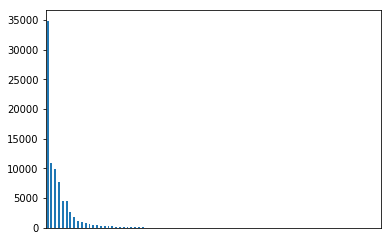

In [74]:
df.model.value_counts().plot.bar()
plt.xticks([])
plt.show()

In [75]:
from scipy import stats

In [76]:
df.model.value_counts() [df.model.value_counts() > 1000]

ST4000DM000                34901
HGST HMS5C4040BLE640       10920
ST8000DM002                 9928
HGST HMS5C4040ALE640        7673
Hitachi HDS5C3030ALA630     4540
Hitachi HDS722020ALA330     4482
Hitachi HDS5C4040ALE630     2639
ST6000DX000                 1890
ST12000NM0007               1104
Name: model, dtype: int64

In [33]:
observed = pd.crosstab(df.model == 'HGST HDS5C4040ALE630', df.early_failure)
observed

early_failure,0,1
model,,
False,79910,3984
True,44,2


In [34]:
chi2, p, degf, expected = stats.chi2_contingency(observed)

print('Observed\n')
print(observed.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed

[[79910  3984]
 [   44     2]]
---
Expected

[[7.99101844e+04 3.98381563e+03]
 [4.38156302e+01 2.18436979e+00]]
---

chi^2 = 0.0479
p     = 0.8267


### H0: model is independent of early failure rate

In [35]:
stats_list = []

for model in df.model.unique():
    observed = pd.crosstab(df.model == model, df.early_failure)
    chi2, p, degf, expected = stats.chi2_contingency(observed)
    
    chi2 = round(chi2,4)
    p = round(p,4)
    signif = p < 0.05
    
    stats_list.append([model, chi2, p, signif])

In [36]:
df_stat = pd.DataFrame(stats_list, columns=['model','chi2', 'p', 'signif'])
df_stat

,model,chi2,p,signif
0,Hitachi HDS5C4040ALE630,132.6020,0.0000,True
1,ST4000DM000,27.3500,0.0000,True
2,Hitachi HDS5C3030ALA630,238.1687,0.0000,True
3,ST8000DM002,95.9810,0.0000,True
4,HGST HMS5C4040BLE640,239.8896,0.0000,True
...,...,...,...,...
83,ST3500320AS,4.5272,0.0334,True
84,WDC WD3200AAKS,4.5272,0.0334,True
85,Hitachi HDS724040ALE640,1.8135,0.1781,False
86,WDC WD2500AAJB,4.5272,0.0334,True


In [37]:
df_stat [df_stat.signif == True]

,model,chi2,p,signif
0,Hitachi HDS5C4040ALE630,132.6020,0.0000,True
1,ST4000DM000,27.3500,0.0000,True
2,Hitachi HDS5C3030ALA630,238.1687,0.0000,True
3,ST8000DM002,95.9810,0.0000,True
4,HGST HMS5C4040BLE640,239.8896,0.0000,True
5,ST500LM012 HN,5.1995,0.0226,True
6,ST6000DX000,43.4400,0.0000,True
7,HGST HMS5C4040ALE640,294.7374,0.0000,True
9,Hitachi HDS722020ALA330,230.5352,0.0000,True
10,WDC WD10EADS,13.3230,0.0003,True


In [38]:
len(df_stat [df_stat.signif == True])

54

In [39]:
stat_sig_models = list(df_stat [df_stat.signif == True].model)

In [40]:
df.model [df.model.isin(stat_sig_models)].value_counts()

ST4000DM000                34901
HGST HMS5C4040BLE640       10920
ST8000DM002                 9928
HGST HMS5C4040ALE640        7673
Hitachi HDS5C3030ALA630     4540
Hitachi HDS722020ALA330     4482
Hitachi HDS5C4040ALE630     2639
ST6000DX000                 1890
ST12000NM0007               1104
Hitachi HDS723030ALA640      995
ST500LM012 HN                603
ST8000NM0055                 442
WDC WD5000LPVX               332
WDC WD10EADS                 287
ST31500541AS                 264
TOSHIBA MQ01ABF050           249
ST4000DX000                  173
TOSHIBA MD04ABA400V          147
WDC WD1600AAJS               100
ST320LT007                    73
HGST HUH728080ALE600          57
ST4000DM001                   34
ST500LM030                    28
HGST HUH721212ALN604          25
TOSHIBA MQ01ABF050M           19
ST10000NM0086                 14
TOSHIBA MG07ACA14TA           11
WDC WD20EFRX                   6
ST4000DM005                    5
ST12000NM0117                  5
HGST HUH72